# Задание 1

Студенты проходили тестирование по финансовой грамотности, результаты измерялись до прохождения курса по управлению финансами и после. Требуется определить, изменились ли в среднем результаты теста и если да, то определить размер эффекта.

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as st
import re
import seaborn as sns
import itertools
from permute.core import one_sample
from statsmodels.stats.descriptivestats import sign_test

### Коментарий к постановке задачи:
После проведения курса по управлению финансами мы ожидаем, что финансовая грамотность студентов не уменьшилась. Поэтому есть смысл проверять также критерии о равенстве средних с односторонней альтернативой
 - $H_0: m_1 = m_2$
 
   $H_1: m_1 \ne m_2$
   
или

 - $H_0: m_1 = m_2$
 
   $H_1: m_1< m_2$ 

### Считываем данные

In [40]:
def read_data(path):
    file = open(path)
    lines = file.read().split("\n")
    file.close()
    
    before = []
    after = []
    for line in lines:
        line = re.sub(' +', ' ', line)
        list_words = line.split(" ")
        if list_words[0] == 'Before':
            before.append(int(list_words[2]))
        if list_words[0] == 'After':
            after.append(int(list_words[2]))
    return np.array(before), np.array(after)

In [41]:
path = "students.txt"
before, after = read_data(path)

### Смотрим на данные

/home/aniro/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/aniro/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


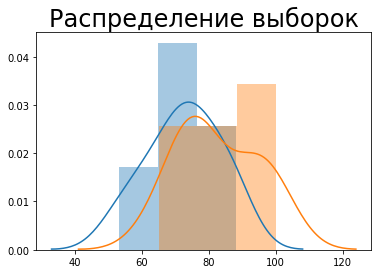

In [57]:
plt.figure()
plt.title('Распределение выборок', fontsize=24) 
sns.distplot(before, label="before")
sns.distplot(after, label="after")
plt.show()

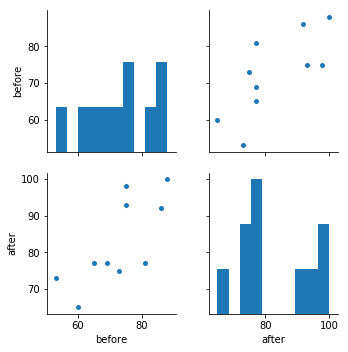

In [58]:
sns.pairplot(pd.DataFrame(data = np.array([before, after]).T, columns = ["before", "after"]))

По графикам видно, что в данных нет явных выбросов.

### Выборки связанные, нам нужно проверить нулевую гипотезу о равенстве матожиданий
Для этого, проверим:
 - Критерий стьюдента для связанных выборок
 - Критерий Уилкокосона для связанных выборок
 - Перестановочный критерий

#### Какие критерии у нас есть, чтобы проверять подобное?
 - t-критерий Стьюдента для связанных выборок(проверить на нормальность!! - у нас достаточно маленькая выборка, с этим могут быть проблемы --- но критерий Стьюдента в принципе не очень чувствителен к отклонениям от нормальности)

### Критерий Стьюдента для связанных выборок

Чтобы применять данный критерий, нам нужно проверить гипотезу о нормальности. Однако, надо понимать, что размер выборки слишком мал(10 значений), чтобы можно было выявить отклонения от нормальности. С другой стороны, t-критерий устойчив к небольшим отклонениям от нормальности, поэтому проверим, что Шапиро не отвергает нормальность и будем использовать t-критерий.

#### Критерий Шапиро не отвергает нормальность:

In [20]:
st.shapiro(before)

(0.9717550873756409, 0.9066238403320312)

In [21]:
st.shapiro(after)

(0.8962869644165039, 0.19936728477478027)

Видим, что гипотеза о нормальности не отклоняется

#### Проводим t-test:

In [37]:
st.ttest_rel(before, after)

Ttest_relResult(statistic=-3.808374649652914, pvalue=0.004163495155629837)

Отклоняем гипотезу о равенстве средних

### Двухвыборочный критерий Уилкоксона

In [32]:
st.wilcoxon(before, after)

WilcoxonResult(statistic=2.0, pvalue=0.00929822320829811)

Отклоняем гипотезу о равентстве в пользу двусторонней альтернативы

### Критерий знаков:

In [12]:
sign_test(before, after)

(-4.0, 0.021484374999999997)

Отклоняем гипотезу о равентстве в пользу двусторонней альтернативы

### Перестановочный критерий:

In [25]:
def permute_test(data1, data2, alternative):
    D = data1 - data2
    t = np.sum(D)
    good = 0
    count = 0
    for v in list(itertools.product([-1, 1], repeat=data1.shape[0])):
        count +=1
        stat = np.array(v).T.dot(D)
        if alternative == "greater":
            if stat >= t:
                good+=1
        if alternative == "lower":
            if stat <= t:
                good+=1
        if alternative == "two-side":
            if abs(stat) >= abs(t):
                good+=1
        
    print("(st =", t, ", p_val =", good/count, ")")


In [28]:
permute_test(before, after, "lower")

(st = -102 , p_val = 0.0029296875 )


In [29]:
permute_test(before, after, "two-side")

(st = -102 , p_val = 0.005859375 )


#### Вывод: гипотеза о равенстве средних отвергается всеми рассмотренными критериями

##  Считаем размер эффекта
Формула подсчета эффекта:
$d = \frac{\bar x_1 - \bar x_2}{s}$

Так, как выборки связанные, читаем, что для подсчета эффекта нужно использовать стандартное отклонение разницы семплов, то есть $s(\vec x_1 - \vec x_2)$

In [31]:
# calculating standart deviation of difference scores:
s = np.std(before - after, ddof=1)
d = (after.mean() - before.mean())/s
d

1.2043138076148991

По таблице смотрим, что размер эффекта - very large